In [1]:
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib import pyplot as plt
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

Most dominant color finder
--
this function is used to find the most dominant color or the blend of most dominant color out for the image

- this program uses kmean clustering to find the most dominat color of all
- the default cluster are taken to be 6 ie predicts the blend of 6 most dominat colors but for our program we take 2 so we get white and the most dominant fruit color
- the color found form this functionis used to fill the fruit image 

In [2]:
#send the most dominat color except white
def findmin(arr):
    arr1=[0,0]
    for i in range (0,2):
        a0=arr[i][0]
        a1=arr[i][1]
        a2=arr[i][2]
        arr1[i]=abs(a0-a1)+abs(a0-a2)+abs(a1-a2)
    if(arr1[0]<arr1[1]):
        return arr[1]
    else:
        return arr[0]
        
#conver rbg to hexa decimal        
def rgb2hex(rgb):
    hex = "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))
    return hex
#print(rgb2hex([255, 0, 0]))     

def plot_image_info(path, k=6 ,show=False):
    # load image
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # resize image to speed up processing time
    resized_img_rgb = cv2.resize(img_rgb, (64, 64), interpolation=cv2.INTER_AREA)

    # reshape the image to be a list of pixels
    img_list = resized_img_rgb.reshape((resized_img_rgb.shape[0] * resized_img_rgb.shape[1], 3))

    # cluster the pixels and assign labels
    clt = KMeans(n_clusters=k)
    labels = clt.fit_predict(img_list)
        
    # count labels to find most popular
    label_counts = Counter(labels)
    total_count = sum(label_counts.values())

    # subset out most popular centroid
    center_colors = list(clt.cluster_centers_)
    ordered_colors = [center_colors[i]/255 for i in label_counts.keys()]
    color_labels = [rgb2hex(ordered_colors[i]*255) for i in label_counts.keys()]
    arr=[ordered_colors[i]*255 for i in label_counts.keys()]
    #print(label_counts.values())
    #print(color_labels)
    if(show):
        # plots
        plt.figure(figsize=(14, 8))
        plt.subplot(221)
        plt.imshow(img_rgb)
        plt.axis('off')

        plt.subplot(222)
        #print("lables_count ",label_counts.values(),"\n color_labels",color_labels,"\nordered_color",ordered_colors)
        plt.pie(list(label_counts.values()), labels=color_labels, colors=ordered_colors)
        plt.axis('equal')
        plt.show()
    return arr
#return the most dominat color in the picture    
def getcolor(path):
    arr=plot_image_info(path,2)
    return(findmin(arr))

In [3]:
from skimage import io
from skimage import feature
from skimage.color import rgb2gray
import os
from glob import glob
import numpy as np

ENCLOSED AREA FINDER
--
this whole function is to join the edges of the image so that it can the find the inside pixels to replace with dominat color
here this function

- `takes the image then converts it into rgb then to grayscale` 
- `then finds its border edges`
- `thickens edges which are nessary and simultaneously removes any noise/unnessary edges present`
- `then joins the edges and create a closed encolsure` 
- `removes extra pixelated values outside the outer edge`
- `sends the processed enclose area to which dominant color can be added`

In [4]:
#function get FILL AREA

"""
this function point c takes input:

img - the image
x,y - the coordinate of the pixel calculate
m,n - the dimension of the fit matrix
t   - the threashold after which the pixel would be illuminated or removed

this function fits the matrix m,n to the neighbouring cell of the point x,y with padding considered #incases of edged border
then this function finds the no of pixelated value in the matrix m,n if the sum is above threashold the it return treu else
it return false

"""
def pointc(img,x,y,m=3,n=3,t=3):
    k=0
    #l=-1*int(z/2)
    #m=int(z/2)+1
    for i in range(-1*int(m/2),int(m/2)+1):
         for j in range(-1*int(n/2),int(n/2)+1):
                if((x+i)<100 and (y+j)<100 and (x+i)>0 and (y+j)>0):
                    if(img[x+i][y+j]):
                        k=k+1
    if(k>t):
        return True
    else:
        return False

    
    
    
"""
this function is used to find the last or the first pixilated value in the whole image 
vertically for a column 
hrizontally for a row

img - image
x   - row no / column no
d   - "h" checking hrizontally / "v" checking vertically
t   - "l" last pixel / "f" first pixel

"""    
#finding last pixeleted value
def lastt(img,x,d='h',t='l'):
    y=0
    if(d=='h' and t=='l'):
        for i in range(0,100):
            if(img[x][i]):
                y=i
    elif(d=='h' and t=='f'):
        for i in range(0,100):
            if(img[x][i]):
                y=i
                break
    elif(d=='v' and t=='l'):
        for i in range(0,100):
            if(img[i][x]):
                y=i
    elif(d=='v' and t=='f'):
        for i in range(0,100):
            if(img[i][x]):
                y=i
                break            
    return y    

'''
this function is for pre processing of data before it is sent for traning
this function takes the image the filter size the threashold and removal situation
the center of the filter is the pixel whoes value is to be checked 
if the sum of all the pixels that lie within the filter is greater than or equal to the threashold then
the value of the pixel is made positive is the rem is true and the sum is less than the threashold then the value of rem is
made to be void/false/0 in  all other cases the values remain same 
'''
def prepro(img,m=3,n=3,t=3,rem=True):
    img1=np.array([[img[x][y] for y in range(100)] for x in range(100)])   
    for i in range(0,100):
        for j in range(0,100):
            if(pointc(img,i,j,m,n,t)):
                img1[i][j]=True
            elif(rem):
                img1[i][j]=False
       #if(i%5==0):
            #io.imshow(img1)
            #ttt=input()
    return img1   

#fill I function to fill the remaning space so that we can get the pixel to fill color
def fill(img):
    img1=np.array([[img[x][y] for y in range(100)] for x in range(100)])   
    flag=False
    for i in range(0,100):
        flag=False
        ll=lastt(img,i)
        for j in range(0,98):
            if(img[i][j]==True):
                if(pointc(img,i,j) or True):
                    if((img[i][j+1]==False)): #and (img[i][j+2]==False)):
                        flag= not flag
                    else:
                        img[i][j]=False
            else:
                if(flag):
                    if(not img[i][j] and j<ll):
                        img1[i][j]=True
            
    return img1         

'''
fill II function to fill the remaning space so that we can get the pixel to fill color
this function takes the image after all the neighbouring cells are connected
this fill function gets the void area to which the dominat color has to be filled 
'''
def fill2(img1):
    arr=[]
    img=np.array([[img1[x][y] for y in range(100)] for x in range(100)]) 
    #horizontal fill f
    for i in range(0,100):
        for j in range(0,lastt(img1,i,'h','f')):
            img[i][j]=True
    #horizontal fill l
    for i in range(0,100):
        for j in range(lastt(img1,i,'h','l'),100):
            img[i][j]=True
    #vertical fill l
    for i in range(0,100):
        for j in range(lastt(img1,i,'v','l'),100):
            img[j][i]=True        
    #vertical fill f
    for i in range(0,100):
        arr+=[lastt(img1,i,'h','f')]
        for j in range(0,lastt(img1,i,'v','f')):
            img[j][i]=True      
    return img   


def getfill(path):
    image = io.imread(path)
    gray = rgb2gray(image)
    edges1 = feature.canny(gray, 0.2, 0.75, 0.4)
    edges1=prepro(edges1,4,4,2)
    edges1=prepro(edges1,1,10,3,False)
    edges1=prepro(edges1,1,10,3,False)
    return(fill2(edges1))

In [5]:
from skimage import io
from skimage import feature
from skimage.color import rgb2gray
import os
from glob import glob

In [6]:
def convert(img):
    img=rgb2gray(img)
    img = feature.canny(img, 0.1, 0.2, 0.25)
    return img

def change(img):
    a=[]
    for i in img:
        s=[]
        for j in i:
            if j:
                s=s+[[255,255,255]]
            else:
                s=s+[[0,0,0]]
        a=a+[s]    
    return a







This is the final function from which all the sub functions are called 
--
this function loads all images form the respective dir and the store the pre-processed image the processed dir
- this function first imports the image
- then finds the canny edge 
- then converts the image form binary form to rgb format
- then finds the fill area 
- then finds the most dominat color for the image 
- after finding the most dominat color
- it merges/overlays all the image following the priority
- toplayer the canny edge
- second layer the fill area with the most dominant color
- the bottom layer being the orignl image 

In [7]:
def edge_grave(x1,x2,x4,col):
    x3 = [[ x1[y][x] for x in range(len(x1[0]))] for y in range(len(x1))] 
    for i in range(0,len(x1)):
        for j in range(0,len(x1[0])):
            if(x2[i][j][0]==255 and x2[i][j][1]==255 and x2[i][j][2]==255):
                x3[i][j]=[0,0,0]
            elif(not x4[i][j]):
                x3[i][j][0]=round(col[0])
                x3[i][j][1]=round(col[1])
                x3[i][j][2]=round(col[2])
            else:
                x3[i][j]=x1[i][j]
                
    return x3   

def load_images(base_path):
    images = []
    path = os.path.join(base_path, '*.jpg')
    for image_path in glob(path):
        #image1 = preprocessing.image.load_img(image_path,target_size=(width, height))
        #x1 = preprocessing.image.img_to_array(image1)
        #image2 = preprocessing.image.load_img(image_path.replace(name,name+'_edge'),target_size=(width, height))
        #x2 = preprocessing.image.img_to_array(image2)
        #images.append([x1,x2])
        x1=io.imread(image_path)
        x2=convert(x1)
        x2=change(x2)
        x3=getfill(image_path)
        col=getcolor(image_path)
        #col=[ round(col[i]) for i in range(3) ]
        x5=edge_grave(x1,x2,x3,col)
        path1=image_path.replace('data','processed_data')
        io.imsave(path1,np.array(x5))


        
        

In [8]:
def dircreate(path):
    try:  
        os.makedirs(path)
    except OSError:  
        print ("Creation of the directory %s failed" % path)
    else:  
        print ("Successfully created the directory %s" % path)
        

In [9]:
def call(fruits):
    for i in fruits:
        base_path='./data/'+i
        dircreate('./processed_data/'+i)
        load_images(base_path)

In [10]:
fruits=['Apple','Banana','Mango','Kiwi','Lime']
fruuu=['test']

call(fruuu)

Successfully created the directory ./processed_data/test


In [11]:
load_images('./data')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./processed_data/84_100.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./processed_data/24_100.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from i

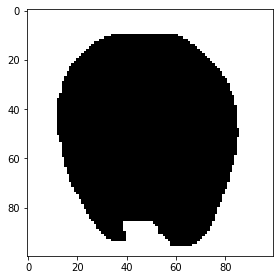

In [12]:
x3=getfill('./data/1.jpg')
io.imshow(x3)

In [13]:
col=getcolor('./data/1.jpg')
round(col[1])

66.0

In [18]:
x1=io.imread('./data/1.jpg')
x2=convert(x1)
x2=change(x2)


In [15]:
io.imshow(x2)

AttributeError: 'list' object has no attribute 'dtype'

In [19]:
x5=edge_grave(x1,x2,x3,col)


In [20]:
print(x3)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [33]:
#io.imsave('./data/2.jpg',np.array(x5))
#np.array(x5)

In [ ]:
 '''   images = []
    path = os.path.join(base_path, '*.jpg')
    for image_path in glob(path):
        #image1 = preprocessing.image.load_img(image_path,target_size=(width, height))
        #x1 = preprocessing.image.img_to_array(image1)
        #image2 = preprocessing.image.load_img(image_path.replace(name,name+'_edge'),target_size=(width, height))
        #x2 = preprocessing.image.img_to_array(image2)
        #images.append([x1,x2])
        x1=io.imread(image_path)
        x2=convert(x1)
        x2=change(x2)
        x3=getfill(image_path)
        col=getcolor(image_path)
        #col=[ round(col[i]) for i in range(3) ]
        x5=edge_grave(x1,x2,x3,col)
        path1=image_path.replace('data','processed_data')
        io.imsave(path1,np.array(x5))'''

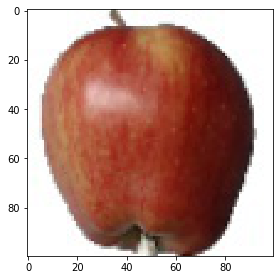

In [21]:
x1=io.imread("./data/1.jpg")
io.imshow(x1)

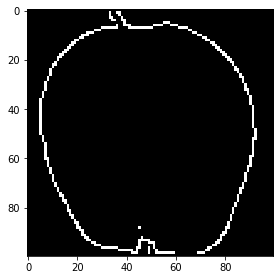

In [22]:
x1=io.imread("./data/1.jpg")
x2=convert(x1)
x2=feature.canny(rgb2gray(x1), 0.8, 0.7, 0)
io.imshow(x2)
x2=change(x2)

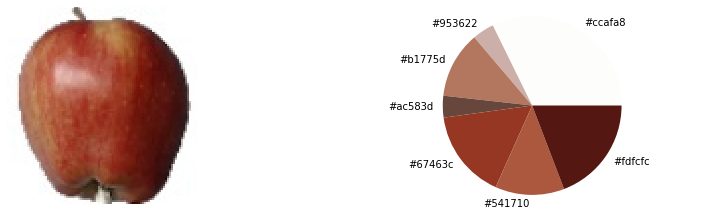

In [23]:
col1=plot_image_info("./test.jpg", 7 ,True)
col=getcolor("./test.jpg")

In [81]:
#image = io.imread(path)
gray = rgb2gray(x1)
#edges1=feature.canny(gray, 0.2, 0.75, 0.4)
edges1=feature.canny(gray, 0.4, 0.75, 0.4)
edges2=prepro(edges1,4,4,2)
edges3=prepro(edges2,1,10,3,False)
edges4=prepro(edges3,1,10,3,False)
x3=fill2(edges4)

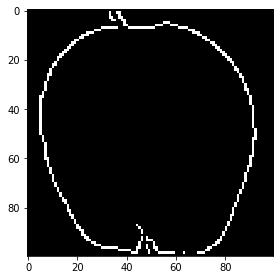

In [82]:
io.imshow(edges1)

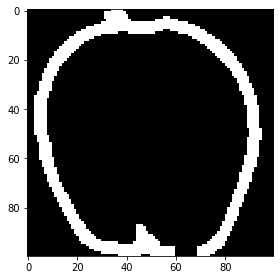

In [83]:
io.imshow(edges2)

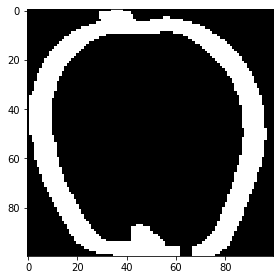

In [84]:
io.imshow(edges3)

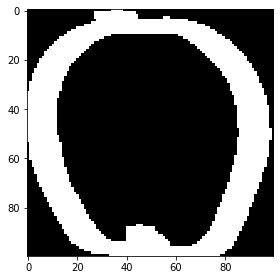

In [85]:
io.imshow(edges4)

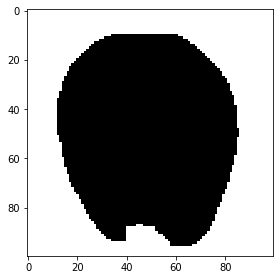

In [86]:
io.imshow(x3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


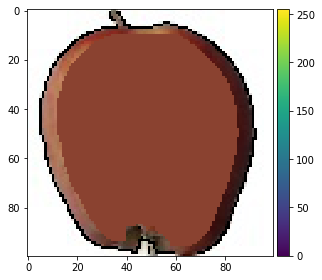

In [87]:
io.imshow(np.array(edge_grave(x1,x2,x3,col)))

In [103]:
io.imsave("./result.jpg",np.array(edge_grave(x1,x2,x3,col)))

C:\Users\Sid\AppData\Local\conda\conda\envs\image\lib\site-packages\skimage\io\_io.py:140: UserWarning: ./result.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Sid\AppData\Local\conda\conda\envs\image\lib\site-packages\skimage\util\dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Sid\AppData\Local\conda\conda\envs\image\lib\site-packages\skimage\util\dtype.py:190: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


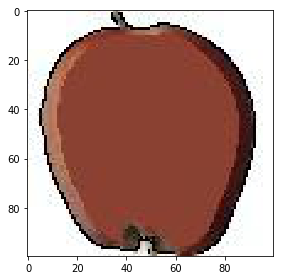

In [104]:
io.imshow(io.imread("./result.jpg"))